In [1]:
LANGUAGE = 'zul'
EXPERIMENT = 'final_ground_truth_active_learning'
PREFERRED_GPU = 'cuda:6' # 'cuda:0'

In [2]:
# Prevent WandB from printing summary in cell output
%env WANDB_SILENT=true

env: WANDB_SILENT=true


In [3]:
import os
import sys
import yaml
import copy
import yaml
import wandb
import torch
import warnings

import torch.nn as nn
from torch.utils.data import DataLoader

from getpass import getpass
from tqdm.notebook import tqdm
from datasets import load_dataset
from sklearn.exceptions import UndefinedMetricWarning
from transformers import AutoTokenizer, get_linear_schedule_with_warmup

torch.cuda.empty_cache()
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [4]:
# Add src module to system path
src_module_path = os.path.abspath('../../../')
if src_module_path not in sys.path:
    sys.path.append(src_module_path)

# Import functions and classes from custom modules
from src.data.preprocess import (
    align_labels_for_many_records,
    TorchDataset,
    balanced_split_for_active_learning
)

from src.utils.utils import (predict_sequence_max_uncertainty,
                             batch_indices_to_global_indices,
                             print_classification_report,
                             calculate_micro_f1_for_batches,
                             calculate_macro_f1_for_batches)
from src.models.xlmr_ner import XLMRobertaForNER

In [5]:
CONFIG_PATH = "../../../settings/config.yml"

In [6]:
# Reading config file
config = yaml.safe_load(open(CONFIG_PATH))

In [7]:
wandb.login(key=getpass("Weights and Biases API key:"))

True

In [8]:
label_mapping = config['label_mapping']
# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Initialize model
base_model = XLMRobertaForNER(model_name=config['model_name'], 
                         num_labels=len(config['label_mapping'].keys()))

# Choose a GPU to use
default_device = config['gpu_settings']['default_device'] if \
    PREFERRED_GPU=='' else PREFERRED_GPU

# Send model to GPU if cuda is available otherwise use CPU
device = torch.device(default_device if torch.cuda.is_available() else "cpu")
print(device)

base_model.to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-mini and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:6


XLMRobertaForNER(
  (xlmr): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 384, padding_idx=1)
      (position_embeddings): Embedding(514, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
          

  0%|          | 0/3 [00:00<?, ?it/s]

Original dataset:
 DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5848
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 836
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1670
    })
})


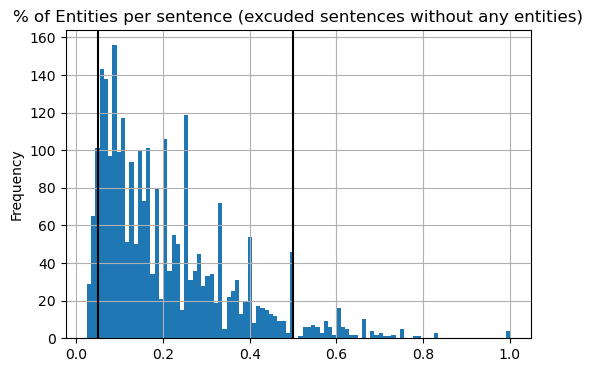

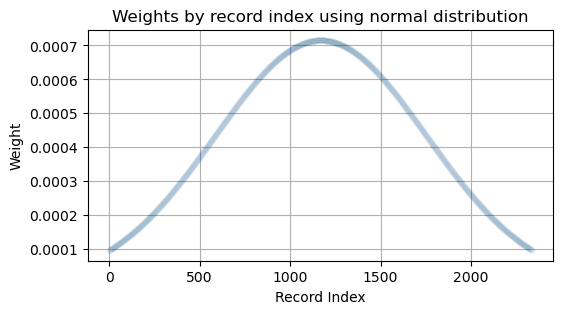

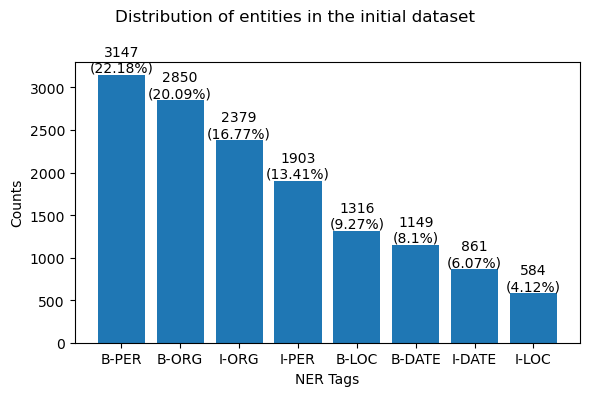

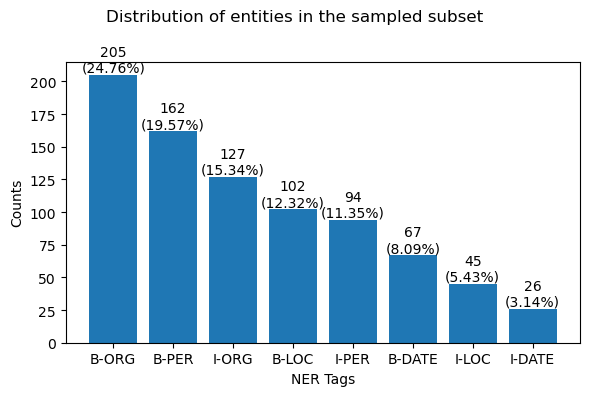

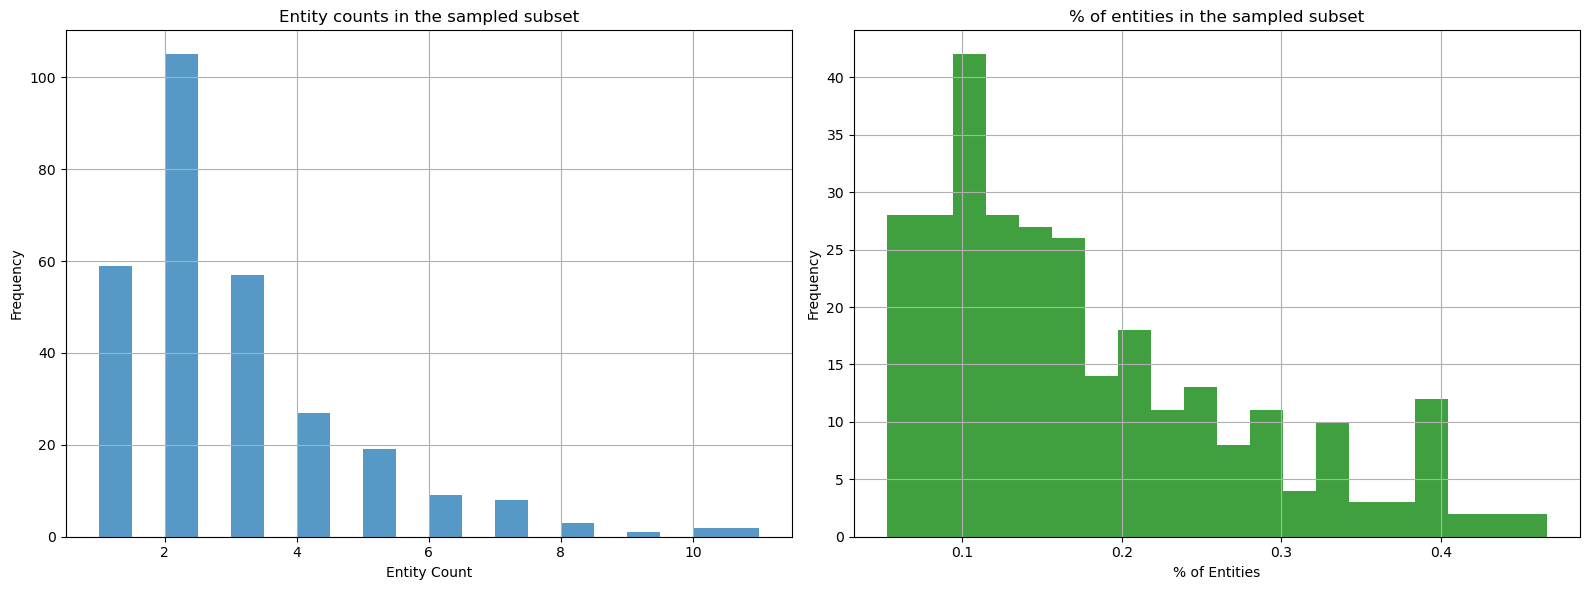

Filter:   0%|          | 0/5848 [00:00<?, ? examples/s]

Split the dataset into initial training (first 5.0%) and active learning (remaining 95.0%).
Overall training dataset size: 5848
Initial training dataset size: 292
Active learning dataset size: 5556


In [9]:
# Download dataset for the specific language 
data = load_dataset(config['dataset'], LANGUAGE)
print("Original dataset:\n", data)

# splitting the data for active learning integration
data = balanced_split_for_active_learning(
    data,
    label_mapping,
    train_key='train',
    split_ratio=config['train_settings']['initial_train_size'],
    verbose=True
)

In [10]:
data = data.map(
    align_labels_for_many_records,
    batched=True,
    fn_kwargs={'tokenizer': tokenizer}
)

Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

In [11]:
# Settings
max_len = config['languages_max_tokens'][LANGUAGE]
print(f'Maximum token length for language {LANGUAGE} is {max_len}')
padding_val = config['tokenizer_settings']['padding_value']

# Convert the datasets.Dataset to a PyTorch Dataset
dataset_init = TorchDataset(data['initial_training'], max_length=max_len, padding_value=padding_val)
dataset_unlabeled = TorchDataset(data['active_learning'], max_length=max_len, padding_value=padding_val)
dataset_test = TorchDataset(data['test'], max_length=max_len, padding_value=padding_val)
dataset_val = TorchDataset(data['validation'],max_length=max_len, padding_value=padding_val)

Maximum token length for language zul is 139


In [12]:
# Settings
batch_size = config['train_settings']['batch_size']
shuffle = config['train_settings']['shuffle']

# Create PyTorch DataLoaders
dataloader_init = DataLoader(dataset_init,
                             batch_size=batch_size,
                             shuffle=shuffle) # Shuffle only training set
dataloader_unlabeled = DataLoader(dataset_unlabeled, batch_size=batch_size)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

In [13]:
def train_ner(model, train_loader, val_loader, device, epochs, lr, updated_dataset_size, num_warmup_steps=5):
    training_history = {
        "train_loss": [],
        "val_loss": [],
        "val_micro_f1": [],
        "val_macro_f1": []
    }
    # Convert lr to float
    lr = float(config['train_settings']['lr'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=num_warmup_steps,
                                                num_training_steps=total_steps)

    # Loss function
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    best_val_f1 = 0.0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask=attention_mask)

            logits_reshaped = logits.view(-1, logits.size(-1))
            labels_reshaped = labels.view(-1)

            # Calculate loss
            loss = loss_fn(logits_reshaped, labels_reshaped)

            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_predictions, val_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Val]", leave=False):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_ids, attention_mask=attention_mask)
                logits_reshaped = logits.view(-1, logits.size(-1))
                labels_reshaped = labels.view(-1)

                # Calculate loss
                loss = loss_fn(logits_reshaped, labels_reshaped)

                total_val_loss += loss.item()

                predictions = torch.argmax(logits, dim=-1)

                val_predictions.append(predictions.detach())
                val_labels.append(batch['labels'].detach())

        avg_val_loss = total_val_loss / len(val_loader)
        micro_f1 = calculate_micro_f1_for_batches(val_predictions, val_labels, ignore_class=0)
        macro_f1 = calculate_macro_f1_for_batches(val_predictions, val_labels, ignore_class=0)

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {micro_f1:.4f}")

        # Update training history
        training_history["train_loss"].append(avg_train_loss)
        training_history["val_loss"].append(avg_val_loss)
        training_history["val_micro_f1"].append(micro_f1)
        training_history["val_macro_f1"].append(macro_f1)

        # WandB logger
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_micro_f1": micro_f1,
            "val_macro_f1": macro_f1,
            "updated_dataset_size": updated_dataset_size
        })

    return model, training_history

In [14]:
# Prepare WandB for initial training
wandb.init(
    project=f'{EXPERIMENT}_{LANGUAGE}',
    name=f'{LANGUAGE}_initial',
    config={
        'epochs': config['train_settings']['epochs'],
        'learning_rate': config['train_settings']['lr'],
        'num_active_learning_rounds': config['active_learning_settings']['num_rounds']
    },
    settings=wandb.Settings(disable_job_creation=True)
)

# create a new model out of base model for re-training and prevent fine-tuning
base_model_for_train = copy.deepcopy(base_model)

# Initial model training
initial_model, history = train_ner(base_model_for_train,
                                   dataloader_init,
                                   dataloader_val,
                                   device,
                                   epochs=config['train_settings']['epochs'],
                                   lr=config['train_settings']['lr'],
                                   updated_dataset_size=len(dataset_init))

# Delete the model as it is no longer utilized.
del base_model_for_train

# Disable WandB logger
wandb.finish()

Epoch 1/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.7425 | Val Loss: 1.1990 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.1361 | Val Loss: 1.0099 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.0177 | Val Loss: 0.9385 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.9515 | Val Loss: 0.8809 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.8962 | Val Loss: 0.8287 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.8459 | Val Loss: 0.7803 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.7995 | Val Loss: 0.7358 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.7590 | Val Loss: 0.6945 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.7212 | Val Loss: 0.6566 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.6826 | Val Loss: 0.6224 | Val F1: 0.0000


Epoch 11/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.6505 | Val Loss: 0.5906 | Val F1: 0.0000


Epoch 12/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.6192 | Val Loss: 0.5620 | Val F1: 0.0000


Epoch 13/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.5927 | Val Loss: 0.5360 | Val F1: 0.0000


Epoch 14/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.5668 | Val Loss: 0.5125 | Val F1: 0.0000


Epoch 15/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.5482 | Val Loss: 0.4913 | Val F1: 0.0000


Epoch 16/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.5304 | Val Loss: 0.4723 | Val F1: 0.0000


Epoch 17/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.5091 | Val Loss: 0.4554 | Val F1: 0.0000


Epoch 18/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.4965 | Val Loss: 0.4400 | Val F1: 0.0000


Epoch 19/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.4778 | Val Loss: 0.4264 | Val F1: 0.0000


Epoch 20/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.4668 | Val Loss: 0.4140 | Val F1: 0.0000


Epoch 21/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.4582 | Val Loss: 0.4028 | Val F1: 0.0000


Epoch 22/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.4453 | Val Loss: 0.3928 | Val F1: 0.0000


Epoch 23/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.4342 | Val Loss: 0.3836 | Val F1: 0.0000


Epoch 24/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.4341 | Val Loss: 0.3751 | Val F1: 0.0000


Epoch 25/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.4183 | Val Loss: 0.3668 | Val F1: 0.0000


Epoch 26/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.4067 | Val Loss: 0.3388 | Val F1: 0.0000


Epoch 27/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.3661 | Val Loss: 0.3128 | Val F1: 0.0000


Epoch 28/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.3450 | Val Loss: 0.3006 | Val F1: 0.0000


Epoch 29/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.3318 | Val Loss: 0.2910 | Val F1: 0.0806


Epoch 30/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.3134 | Val Loss: 0.2815 | Val F1: 0.1397


Epoch 31/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.2982 | Val Loss: 0.2744 | Val F1: 0.1502


Epoch 32/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.2846 | Val Loss: 0.2682 | Val F1: 0.1543


Epoch 33/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.2790 | Val Loss: 0.2599 | Val F1: 0.4022


Epoch 34/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.2675 | Val Loss: 0.2526 | Val F1: 0.4534


Epoch 35/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.2617 | Val Loss: 0.2465 | Val F1: 0.4667


Epoch 36/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.2544 | Val Loss: 0.2412 | Val F1: 0.4800


Epoch 37/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.2467 | Val Loss: 0.2349 | Val F1: 0.4624


Epoch 38/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.2449 | Val Loss: 0.2307 | Val F1: 0.4673


Epoch 39/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.2373 | Val Loss: 0.2272 | Val F1: 0.4828


Epoch 40/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.2303 | Val Loss: 0.2237 | Val F1: 0.4840


Epoch 41/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.2288 | Val Loss: 0.2228 | Val F1: 0.5180


Epoch 42/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.2264 | Val Loss: 0.2181 | Val F1: 0.4881


Epoch 43/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.2259 | Val Loss: 0.2166 | Val F1: 0.5207


Epoch 44/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.2208 | Val Loss: 0.2143 | Val F1: 0.5264


Epoch 45/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.2179 | Val Loss: 0.2125 | Val F1: 0.5254


Epoch 46/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.2147 | Val Loss: 0.2107 | Val F1: 0.5233


Epoch 47/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.2134 | Val Loss: 0.2102 | Val F1: 0.5282


Epoch 48/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.2136 | Val Loss: 0.2095 | Val F1: 0.5254


Epoch 49/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.2126 | Val Loss: 0.2090 | Val F1: 0.5272


Epoch 50/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.2139 | Val Loss: 0.2087 | Val F1: 0.5274


In [15]:
# Model evaluation before re-training
print_classification_report(config, initial_model, dataloader_test, device, ignore_index=-100, ignore_class=0)

[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00       926
       B-LOC       0.53      0.79      0.63      1288
       B-ORG       0.50      0.75      0.60      1099
       B-PER       0.67      0.94      0.78      2753
      I-DATE       0.00      0.00      0.00       412
       I-LOC       0.00      0.00      0.00       237
       I-ORG       0.00      0.00      0.00       533
       I-PER       0.00      0.00      0.00      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.53      8405
   macro avg       0.19      0.27      0.22      8405
weighted avg       0.37      0.53      0.43      8405



In [16]:
# Select initial model as best model for the first round of active learning
best_model = copy.deepcopy(initial_model)

# Delete the model as it is no longer utilized.
del initial_model

# Use initial dataset to be combined with re-annotated uncertain samples for first round of active learning 
combined_dataset = copy.deepcopy(dataset_init)

# create a copy of active learning set and its ids to exclude last round samples easier duing active learning
active_learning_set = data['active_learning']

# Active learning framework
for round in range(config['active_learning_settings']['num_rounds']):
    print(10*"=" + f" Active Learning - Round {round+1} " + 10*"=")
    # Prepare WandB for active learning
    wandb.init(
        project=f'{EXPERIMENT}_{LANGUAGE}',
        name=f'{LANGUAGE}_round_{round+1}',
        config={
            'epochs': config['train_settings']['epochs'],
            'learning_rate': config['train_settings']['lr'],
            'num_active_learning_rounds': config['active_learning_settings']['num_rounds']
        },
        settings=wandb.Settings(disable_job_creation=True)
    )

    uncertain_samples = predict_sequence_max_uncertainty(
        best_model,
        dataloader_unlabeled,
        device,
        fraction=config['train_settings']['label_fraction']
    )

    # Delete the model as it is no longer utilized.
    del best_model

    global_indices = batch_indices_to_global_indices(uncertain_samples,
                                                    batch_size)

    # Create a subset from the pseudo-unlabeled data
    dataset_tune = data['active_learning'].select(global_indices)

    # Convert datasets.dataset to PyTorch dataset
    converted_dataset_tune = TorchDataset(dataset_tune,
                                        max_length=max_len,
                                        padding_value=padding_val)

    # Combine previous training data with newly labeled data
    combined_dataset = torch.utils.data.ConcatDataset([combined_dataset,
                                                    converted_dataset_tune])
    print("Size of updated re-training dataset: ", len(combined_dataset))

    # Create dataloader
    dataloader_tune = DataLoader(combined_dataset, batch_size=batch_size)

    # create a new model out of base model for re-training and prevent fine-tuning
    base_model_for_train = copy.deepcopy(base_model)

    # Re-train the model
    best_model, history = train_ner(base_model_for_train,
                                    dataloader_tune,
                                    dataloader_val,
                                    device,
                                    epochs=config['train_settings']['epochs'],
                                    lr=config['train_settings']['lr'],
                                    updated_dataset_size=len(combined_dataset))
    
    # Delete the model as it is no longer utilized.
    del base_model_for_train

    # Model evaluation after each round of active learning
    print_classification_report(config, best_model, dataloader_test, device, ignore_index=-100, ignore_class=0)

    # Disable WandB logger
    wandb.finish()

========== Active Learning - Round 1 ==========
Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  569


Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.5503 | Val Loss: 1.0275 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.1096 | Val Loss: 0.8953 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.0101 | Val Loss: 0.7966 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.9312 | Val Loss: 0.7113 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.8640 | Val Loss: 0.6382 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.7969 | Val Loss: 0.5711 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.6917 | Val Loss: 0.4891 | Val F1: 0.0814


Epoch 8/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.6047 | Val Loss: 0.4252 | Val F1: 0.1759


Epoch 9/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.5314 | Val Loss: 0.3779 | Val F1: 0.4701


Epoch 10/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.4661 | Val Loss: 0.3216 | Val F1: 0.5878


Epoch 11/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.4117 | Val Loss: 0.2876 | Val F1: 0.6651


Epoch 12/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.3654 | Val Loss: 0.2553 | Val F1: 0.7660


Epoch 13/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.3257 | Val Loss: 0.2273 | Val F1: 0.7907


Epoch 14/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.2936 | Val Loss: 0.2061 | Val F1: 0.7993


Epoch 15/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.2667 | Val Loss: 0.1905 | Val F1: 0.8171


Epoch 16/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.2470 | Val Loss: 0.1773 | Val F1: 0.8101


Epoch 17/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.2296 | Val Loss: 0.1644 | Val F1: 0.7999


Epoch 18/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.2154 | Val Loss: 0.1561 | Val F1: 0.8079


Epoch 19/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.2029 | Val Loss: 0.1484 | Val F1: 0.8077


Epoch 20/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.1916 | Val Loss: 0.1400 | Val F1: 0.8232


Epoch 21/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.1825 | Val Loss: 0.1344 | Val F1: 0.8128


Epoch 22/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.1752 | Val Loss: 0.1273 | Val F1: 0.8261


Epoch 23/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.1676 | Val Loss: 0.1238 | Val F1: 0.8167


Epoch 24/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.1593 | Val Loss: 0.1194 | Val F1: 0.8339


Epoch 25/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.1543 | Val Loss: 0.1164 | Val F1: 0.8155


Epoch 26/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1481 | Val Loss: 0.1129 | Val F1: 0.8271


Epoch 27/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1425 | Val Loss: 0.1088 | Val F1: 0.8365


Epoch 28/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.1379 | Val Loss: 0.1059 | Val F1: 0.8335


Epoch 29/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.1340 | Val Loss: 0.1045 | Val F1: 0.8382


Epoch 30/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.1295 | Val Loss: 0.1035 | Val F1: 0.8335


Epoch 31/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.1262 | Val Loss: 0.1003 | Val F1: 0.8423


Epoch 32/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.1211 | Val Loss: 0.0986 | Val F1: 0.8421


Epoch 33/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.1182 | Val Loss: 0.0967 | Val F1: 0.8513


Epoch 34/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.1146 | Val Loss: 0.0949 | Val F1: 0.8564


Epoch 35/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.1120 | Val Loss: 0.0935 | Val F1: 0.8494


Epoch 36/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.1100 | Val Loss: 0.0924 | Val F1: 0.8650


Epoch 37/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.1066 | Val Loss: 0.0917 | Val F1: 0.8625


Epoch 38/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.1050 | Val Loss: 0.0914 | Val F1: 0.8527


Epoch 39/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.1026 | Val Loss: 0.0905 | Val F1: 0.8478


Epoch 40/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.1011 | Val Loss: 0.0892 | Val F1: 0.8568


Epoch 41/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0987 | Val Loss: 0.0886 | Val F1: 0.8554


Epoch 42/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0979 | Val Loss: 0.0880 | Val F1: 0.8523


Epoch 43/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0970 | Val Loss: 0.0874 | Val F1: 0.8527


Epoch 44/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0962 | Val Loss: 0.0870 | Val F1: 0.8635


Epoch 45/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0949 | Val Loss: 0.0862 | Val F1: 0.8642


Epoch 46/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0939 | Val Loss: 0.0854 | Val F1: 0.8617


Epoch 47/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0936 | Val Loss: 0.0853 | Val F1: 0.8592


Epoch 48/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0933 | Val Loss: 0.0852 | Val F1: 0.8635


Epoch 49/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0927 | Val Loss: 0.0851 | Val F1: 0.8633


Epoch 50/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0933 | Val Loss: 0.0851 | Val F1: 0.8635


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.94      0.81      0.87       926
       B-LOC       0.87      0.89      0.88      1288
       B-ORG       0.85      0.79      0.81      1099
       B-PER       0.97      0.90      0.93      2753
      I-DATE       0.89      0.63      0.74       412
       I-LOC       0.82      0.71      0.76       237
       I-ORG       0.87      0.70      0.78       533
       I-PER       0.89      0.97      0.93      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.85      8405
   macro avg       0.79      0.71      0.74      8405
weighted avg       0.91      0.85      0.88      8405

========== Active Learning - Round 2 ==========


Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  846


Epoch 1/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.4716 | Val Loss: 0.9598 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0829 | Val Loss: 0.8010 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.9694 | Val Loss: 0.6777 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.8819 | Val Loss: 0.5812 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.7242 | Val Loss: 0.4600 | Val F1: 0.2083


Epoch 6/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.5738 | Val Loss: 0.3594 | Val F1: 0.5947


Epoch 7/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.4571 | Val Loss: 0.2875 | Val F1: 0.7721


Epoch 8/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.3739 | Val Loss: 0.2397 | Val F1: 0.7891


Epoch 9/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.3153 | Val Loss: 0.2010 | Val F1: 0.8093


Epoch 10/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.2748 | Val Loss: 0.1757 | Val F1: 0.8030


Epoch 11/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.2427 | Val Loss: 0.1580 | Val F1: 0.8261


Epoch 12/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.2174 | Val Loss: 0.1427 | Val F1: 0.8353


Epoch 13/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.1973 | Val Loss: 0.1311 | Val F1: 0.8468


Epoch 14/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.1809 | Val Loss: 0.1218 | Val F1: 0.8666


Epoch 15/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.1682 | Val Loss: 0.1147 | Val F1: 0.8672


Epoch 16/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.1532 | Val Loss: 0.1055 | Val F1: 0.8541


Epoch 17/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.1402 | Val Loss: 0.1010 | Val F1: 0.8637


Epoch 18/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.1300 | Val Loss: 0.0961 | Val F1: 0.8494


Epoch 19/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.1233 | Val Loss: 0.0929 | Val F1: 0.8695


Epoch 20/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.1150 | Val Loss: 0.0900 | Val F1: 0.8637


Epoch 21/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.1081 | Val Loss: 0.0849 | Val F1: 0.8590


Epoch 22/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.1003 | Val Loss: 0.0840 | Val F1: 0.8609


Epoch 23/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0951 | Val Loss: 0.0801 | Val F1: 0.8660


Epoch 24/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0910 | Val Loss: 0.0800 | Val F1: 0.8734


Epoch 25/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0861 | Val Loss: 0.0764 | Val F1: 0.8656


Epoch 26/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0826 | Val Loss: 0.0753 | Val F1: 0.8650


Epoch 27/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0789 | Val Loss: 0.0724 | Val F1: 0.8762


Epoch 28/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0751 | Val Loss: 0.0725 | Val F1: 0.8584


Epoch 29/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0723 | Val Loss: 0.0721 | Val F1: 0.8554


Epoch 30/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0699 | Val Loss: 0.0699 | Val F1: 0.8568


Epoch 31/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0676 | Val Loss: 0.0694 | Val F1: 0.8781


Epoch 32/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0646 | Val Loss: 0.0694 | Val F1: 0.8584


Epoch 33/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0629 | Val Loss: 0.0687 | Val F1: 0.8766


Epoch 34/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0609 | Val Loss: 0.0672 | Val F1: 0.8650


Epoch 35/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0588 | Val Loss: 0.0673 | Val F1: 0.8680


Epoch 36/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0574 | Val Loss: 0.0671 | Val F1: 0.8664


Epoch 37/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0564 | Val Loss: 0.0665 | Val F1: 0.8637


Epoch 38/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0544 | Val Loss: 0.0673 | Val F1: 0.8525


Epoch 39/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0534 | Val Loss: 0.0671 | Val F1: 0.8547


Epoch 40/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0526 | Val Loss: 0.0675 | Val F1: 0.8529


Epoch 41/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0515 | Val Loss: 0.0656 | Val F1: 0.8617


Epoch 42/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0507 | Val Loss: 0.0653 | Val F1: 0.8640


Epoch 43/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0503 | Val Loss: 0.0652 | Val F1: 0.8693


Epoch 44/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0493 | Val Loss: 0.0648 | Val F1: 0.8703


Epoch 45/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0487 | Val Loss: 0.0646 | Val F1: 0.8660


Epoch 46/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0483 | Val Loss: 0.0645 | Val F1: 0.8687


Epoch 47/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0477 | Val Loss: 0.0645 | Val F1: 0.8693


Epoch 48/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0474 | Val Loss: 0.0645 | Val F1: 0.8662


Epoch 49/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0474 | Val Loss: 0.0646 | Val F1: 0.8652


Epoch 50/50 [Train]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0471 | Val Loss: 0.0646 | Val F1: 0.8648


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.94      0.84      0.89       926
       B-LOC       0.87      0.90      0.88      1288
       B-ORG       0.87      0.81      0.84      1099
       B-PER       0.97      0.91      0.94      2753
      I-DATE       0.90      0.65      0.76       412
       I-LOC       0.80      0.84      0.82       237
       I-ORG       0.89      0.81      0.85       533
       I-PER       0.93      0.96      0.95      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.87      8405
   macro avg       0.80      0.75      0.77      8405
weighted avg       0.92      0.87      0.90      8405

========== Active Learning - Round 3 ==========


Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  1123


Epoch 1/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.3882 | Val Loss: 0.9027 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0455 | Val Loss: 0.7189 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.8879 | Val Loss: 0.5503 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.6605 | Val Loss: 0.3949 | Val F1: 0.4859


Epoch 5/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.4866 | Val Loss: 0.2921 | Val F1: 0.7653


Epoch 6/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.3691 | Val Loss: 0.2268 | Val F1: 0.8132


Epoch 7/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.2980 | Val Loss: 0.1854 | Val F1: 0.8085


Epoch 8/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.2499 | Val Loss: 0.1576 | Val F1: 0.8576


Epoch 9/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.2141 | Val Loss: 0.1418 | Val F1: 0.8687


Epoch 10/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.1869 | Val Loss: 0.1262 | Val F1: 0.8697


Epoch 11/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.1640 | Val Loss: 0.1129 | Val F1: 0.8484


Epoch 12/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.1451 | Val Loss: 0.1017 | Val F1: 0.8521


Epoch 13/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.1310 | Val Loss: 0.0964 | Val F1: 0.8793


Epoch 14/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.1183 | Val Loss: 0.0894 | Val F1: 0.8580


Epoch 15/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.1082 | Val Loss: 0.0852 | Val F1: 0.8588


Epoch 16/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0992 | Val Loss: 0.0813 | Val F1: 0.8572


Epoch 17/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0901 | Val Loss: 0.0779 | Val F1: 0.8676


Epoch 18/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0833 | Val Loss: 0.0753 | Val F1: 0.8650


Epoch 19/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0790 | Val Loss: 0.0744 | Val F1: 0.8486


Epoch 20/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0722 | Val Loss: 0.0715 | Val F1: 0.8574


Epoch 21/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0679 | Val Loss: 0.0732 | Val F1: 0.8480


Epoch 22/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0643 | Val Loss: 0.0695 | Val F1: 0.8629


Epoch 23/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0602 | Val Loss: 0.0666 | Val F1: 0.8674


Epoch 24/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0577 | Val Loss: 0.0666 | Val F1: 0.8658


Epoch 25/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0537 | Val Loss: 0.0667 | Val F1: 0.8635


Epoch 26/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0513 | Val Loss: 0.0641 | Val F1: 0.8756


Epoch 27/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0489 | Val Loss: 0.0644 | Val F1: 0.8750


Epoch 28/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0467 | Val Loss: 0.0630 | Val F1: 0.8576


Epoch 29/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0456 | Val Loss: 0.0645 | Val F1: 0.8744


Epoch 30/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0425 | Val Loss: 0.0634 | Val F1: 0.8654


Epoch 31/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0404 | Val Loss: 0.0629 | Val F1: 0.8736


Epoch 32/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0382 | Val Loss: 0.0631 | Val F1: 0.8640


Epoch 33/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0370 | Val Loss: 0.0625 | Val F1: 0.8660


Epoch 34/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0346 | Val Loss: 0.0614 | Val F1: 0.8635


Epoch 35/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0331 | Val Loss: 0.0609 | Val F1: 0.8644


Epoch 36/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0320 | Val Loss: 0.0601 | Val F1: 0.8695


Epoch 37/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0303 | Val Loss: 0.0600 | Val F1: 0.8607


Epoch 38/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0291 | Val Loss: 0.0596 | Val F1: 0.8584


Epoch 39/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0281 | Val Loss: 0.0595 | Val F1: 0.8721


Epoch 40/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0272 | Val Loss: 0.0595 | Val F1: 0.8691


Epoch 41/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0268 | Val Loss: 0.0593 | Val F1: 0.8717


Epoch 42/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0257 | Val Loss: 0.0599 | Val F1: 0.8687


Epoch 43/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0253 | Val Loss: 0.0593 | Val F1: 0.8709


Epoch 44/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0247 | Val Loss: 0.0592 | Val F1: 0.8721


Epoch 45/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0244 | Val Loss: 0.0597 | Val F1: 0.8734


Epoch 46/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0237 | Val Loss: 0.0597 | Val F1: 0.8658


Epoch 47/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0236 | Val Loss: 0.0593 | Val F1: 0.8709


Epoch 48/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0231 | Val Loss: 0.0592 | Val F1: 0.8725


Epoch 49/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0232 | Val Loss: 0.0594 | Val F1: 0.8719


Epoch 50/50 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0230 | Val Loss: 0.0595 | Val F1: 0.8701


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.95      0.87      0.91       926
       B-LOC       0.90      0.90      0.90      1288
       B-ORG       0.89      0.81      0.85      1099
       B-PER       0.96      0.92      0.94      2753
      I-DATE       0.93      0.68      0.79       412
       I-LOC       0.87      0.82      0.85       237
       I-ORG       0.84      0.81      0.83       533
       I-PER       0.90      0.96      0.93      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.88      8405
   macro avg       0.81      0.75      0.78      8405
weighted avg       0.92      0.88      0.90      8405

========== Active Learning - Round 4 ==========


Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  1400


Epoch 1/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.3444 | Val Loss: 0.8550 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.9987 | Val Loss: 0.6323 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.7261 | Val Loss: 0.4201 | Val F1: 0.4789


Epoch 4/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.4936 | Val Loss: 0.2863 | Val F1: 0.7889


Epoch 5/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.3553 | Val Loss: 0.2125 | Val F1: 0.8247


Epoch 6/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.2774 | Val Loss: 0.1656 | Val F1: 0.8502


Epoch 7/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.2236 | Val Loss: 0.1365 | Val F1: 0.8521


Epoch 8/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.1869 | Val Loss: 0.1212 | Val F1: 0.8597


Epoch 9/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.1597 | Val Loss: 0.1068 | Val F1: 0.8713


Epoch 10/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.1373 | Val Loss: 0.0959 | Val F1: 0.8564


Epoch 11/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.1200 | Val Loss: 0.0886 | Val F1: 0.8668


Epoch 12/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.1061 | Val Loss: 0.0830 | Val F1: 0.8541


Epoch 13/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0947 | Val Loss: 0.0774 | Val F1: 0.8654


Epoch 14/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0849 | Val Loss: 0.0766 | Val F1: 0.8674


Epoch 15/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0770 | Val Loss: 0.0730 | Val F1: 0.8660


Epoch 16/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0701 | Val Loss: 0.0705 | Val F1: 0.8642


Epoch 17/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0646 | Val Loss: 0.0687 | Val F1: 0.8629


Epoch 18/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0595 | Val Loss: 0.0670 | Val F1: 0.8697


Epoch 19/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0548 | Val Loss: 0.0660 | Val F1: 0.8531


Epoch 20/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0505 | Val Loss: 0.0646 | Val F1: 0.8738


Epoch 21/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0470 | Val Loss: 0.0652 | Val F1: 0.8609


Epoch 22/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0432 | Val Loss: 0.0642 | Val F1: 0.8519


Epoch 23/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0399 | Val Loss: 0.0635 | Val F1: 0.8578


Epoch 24/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0368 | Val Loss: 0.0647 | Val F1: 0.8609


Epoch 25/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0354 | Val Loss: 0.0628 | Val F1: 0.8779


Epoch 26/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0321 | Val Loss: 0.0621 | Val F1: 0.8680


Epoch 27/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0299 | Val Loss: 0.0605 | Val F1: 0.8744


Epoch 28/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0268 | Val Loss: 0.0602 | Val F1: 0.8723


Epoch 29/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0249 | Val Loss: 0.0607 | Val F1: 0.8750


Epoch 30/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0236 | Val Loss: 0.0609 | Val F1: 0.8750


Epoch 31/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0226 | Val Loss: 0.0606 | Val F1: 0.8807


Epoch 32/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0212 | Val Loss: 0.0599 | Val F1: 0.8828


Epoch 33/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0204 | Val Loss: 0.0614 | Val F1: 0.8791


Epoch 34/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0195 | Val Loss: 0.0611 | Val F1: 0.8672


Epoch 35/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0184 | Val Loss: 0.0623 | Val F1: 0.8592


Epoch 36/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0176 | Val Loss: 0.0617 | Val F1: 0.8640


Epoch 37/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0174 | Val Loss: 0.0611 | Val F1: 0.8674


Epoch 38/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0165 | Val Loss: 0.0611 | Val F1: 0.8744


Epoch 39/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0164 | Val Loss: 0.0659 | Val F1: 0.8599


Epoch 40/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0156 | Val Loss: 0.0653 | Val F1: 0.8727


Epoch 41/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0151 | Val Loss: 0.0637 | Val F1: 0.8670


Epoch 42/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0149 | Val Loss: 0.0641 | Val F1: 0.8644


Epoch 43/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0145 | Val Loss: 0.0637 | Val F1: 0.8742


Epoch 44/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0140 | Val Loss: 0.0634 | Val F1: 0.8717


Epoch 45/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0134 | Val Loss: 0.0640 | Val F1: 0.8685


Epoch 46/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0131 | Val Loss: 0.0646 | Val F1: 0.8699


Epoch 47/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0130 | Val Loss: 0.0630 | Val F1: 0.8680


Epoch 48/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0132 | Val Loss: 0.0627 | Val F1: 0.8711


Epoch 49/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0130 | Val Loss: 0.0629 | Val F1: 0.8703


Epoch 50/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0128 | Val Loss: 0.0630 | Val F1: 0.8711


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.86      0.90       926
       B-LOC       0.91      0.91      0.91      1288
       B-ORG       0.90      0.82      0.85      1099
       B-PER       0.97      0.91      0.94      2753
      I-DATE       0.95      0.69      0.80       412
       I-LOC       0.86      0.85      0.86       237
       I-ORG       0.87      0.81      0.84       533
       I-PER       0.89      0.97      0.93      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.88      8405
   macro avg       0.81      0.76      0.78      8405
weighted avg       0.93      0.88      0.90      8405

========== Active Learning - Round 5 ==========


Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  1677


Epoch 1/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.3143 | Val Loss: 0.8065 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.9383 | Val Loss: 0.5423 | Val F1: 0.1448


Epoch 3/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.5994 | Val Loss: 0.3274 | Val F1: 0.7930


Epoch 4/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.3870 | Val Loss: 0.2193 | Val F1: 0.8196


Epoch 5/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.2836 | Val Loss: 0.1641 | Val F1: 0.8257


Epoch 6/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.2214 | Val Loss: 0.1322 | Val F1: 0.8210


Epoch 7/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.1801 | Val Loss: 0.1125 | Val F1: 0.8560


Epoch 8/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.1483 | Val Loss: 0.0986 | Val F1: 0.8355


Epoch 9/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.1267 | Val Loss: 0.0887 | Val F1: 0.8398


Epoch 10/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.1081 | Val Loss: 0.0819 | Val F1: 0.8619


Epoch 11/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0935 | Val Loss: 0.0777 | Val F1: 0.8627


Epoch 12/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0825 | Val Loss: 0.0721 | Val F1: 0.8707


Epoch 13/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0734 | Val Loss: 0.0702 | Val F1: 0.8695


Epoch 14/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0653 | Val Loss: 0.0672 | Val F1: 0.8552


Epoch 15/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0573 | Val Loss: 0.0648 | Val F1: 0.8572


Epoch 16/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0514 | Val Loss: 0.0627 | Val F1: 0.8717


Epoch 17/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0462 | Val Loss: 0.0608 | Val F1: 0.8760


Epoch 18/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0419 | Val Loss: 0.0606 | Val F1: 0.8566


Epoch 19/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0380 | Val Loss: 0.0592 | Val F1: 0.8687


Epoch 20/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0338 | Val Loss: 0.0584 | Val F1: 0.8672


Epoch 21/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0312 | Val Loss: 0.0576 | Val F1: 0.8818


Epoch 22/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0288 | Val Loss: 0.0546 | Val F1: 0.8875


Epoch 23/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0253 | Val Loss: 0.0555 | Val F1: 0.8797


Epoch 24/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0231 | Val Loss: 0.0575 | Val F1: 0.8750


Epoch 25/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0214 | Val Loss: 0.0581 | Val F1: 0.8775


Epoch 26/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0202 | Val Loss: 0.0607 | Val F1: 0.8869


Epoch 27/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0186 | Val Loss: 0.0570 | Val F1: 0.8768


Epoch 28/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0178 | Val Loss: 0.0576 | Val F1: 0.8689


Epoch 29/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0166 | Val Loss: 0.0574 | Val F1: 0.8783


Epoch 30/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0156 | Val Loss: 0.0607 | Val F1: 0.8793


Epoch 31/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0147 | Val Loss: 0.0619 | Val F1: 0.8748


Epoch 32/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0140 | Val Loss: 0.0585 | Val F1: 0.8770


Epoch 33/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0132 | Val Loss: 0.0600 | Val F1: 0.8803


Epoch 34/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0127 | Val Loss: 0.0610 | Val F1: 0.8701


Epoch 35/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0119 | Val Loss: 0.0586 | Val F1: 0.8623


Epoch 36/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0111 | Val Loss: 0.0595 | Val F1: 0.8781


Epoch 37/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0107 | Val Loss: 0.0613 | Val F1: 0.8562


Epoch 38/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0099 | Val Loss: 0.0624 | Val F1: 0.8717


Epoch 39/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0098 | Val Loss: 0.0615 | Val F1: 0.8595


Epoch 40/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0096 | Val Loss: 0.0624 | Val F1: 0.8734


Epoch 41/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0090 | Val Loss: 0.0618 | Val F1: 0.8666


Epoch 42/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0088 | Val Loss: 0.0644 | Val F1: 0.8646


Epoch 43/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0086 | Val Loss: 0.0639 | Val F1: 0.8693


Epoch 44/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0082 | Val Loss: 0.0632 | Val F1: 0.8662


Epoch 45/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0081 | Val Loss: 0.0628 | Val F1: 0.8689


Epoch 46/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0078 | Val Loss: 0.0629 | Val F1: 0.8713


Epoch 47/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0078 | Val Loss: 0.0628 | Val F1: 0.8744


Epoch 48/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0077 | Val Loss: 0.0629 | Val F1: 0.8719


Epoch 49/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0077 | Val Loss: 0.0630 | Val F1: 0.8719


Epoch 50/50 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0076 | Val Loss: 0.0628 | Val F1: 0.8744


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.87      0.91       926
       B-LOC       0.92      0.90      0.91      1288
       B-ORG       0.87      0.83      0.85      1099
       B-PER       0.97      0.90      0.93      2753
      I-DATE       0.93      0.72      0.81       412
       I-LOC       0.88      0.87      0.87       237
       I-ORG       0.93      0.81      0.87       533
       I-PER       0.88      0.96      0.92      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.88      8405
   macro avg       0.82      0.76      0.79      8405
weighted avg       0.93      0.88      0.90      8405

========== Active Learning - Round 6 ==========


Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  1954


Epoch 1/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.2702 | Val Loss: 0.7621 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.8528 | Val Loss: 0.4545 | Val F1: 0.2944


Epoch 3/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.5016 | Val Loss: 0.2649 | Val F1: 0.7703


Epoch 4/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.3226 | Val Loss: 0.1769 | Val F1: 0.8263


Epoch 5/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.2353 | Val Loss: 0.1349 | Val F1: 0.8435


Epoch 6/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.1789 | Val Loss: 0.1111 | Val F1: 0.8124


Epoch 7/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.1436 | Val Loss: 0.0962 | Val F1: 0.8466


Epoch 8/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.1183 | Val Loss: 0.0821 | Val F1: 0.8394


Epoch 9/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.0995 | Val Loss: 0.0760 | Val F1: 0.8517


Epoch 10/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.0843 | Val Loss: 0.0709 | Val F1: 0.8449


Epoch 11/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0723 | Val Loss: 0.0676 | Val F1: 0.8554


Epoch 12/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0628 | Val Loss: 0.0672 | Val F1: 0.8378


Epoch 13/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0545 | Val Loss: 0.0634 | Val F1: 0.8660


Epoch 14/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0496 | Val Loss: 0.0613 | Val F1: 0.8678


Epoch 15/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0428 | Val Loss: 0.0620 | Val F1: 0.8500


Epoch 16/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0373 | Val Loss: 0.0583 | Val F1: 0.8633


Epoch 17/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0324 | Val Loss: 0.0578 | Val F1: 0.8427


Epoch 18/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0306 | Val Loss: 0.0555 | Val F1: 0.8732


Epoch 19/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0258 | Val Loss: 0.0560 | Val F1: 0.8805


Epoch 20/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0233 | Val Loss: 0.0588 | Val F1: 0.8674


Epoch 21/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0210 | Val Loss: 0.0603 | Val F1: 0.8842


Epoch 22/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0188 | Val Loss: 0.0580 | Val F1: 0.8556


Epoch 23/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0173 | Val Loss: 0.0601 | Val F1: 0.8586


Epoch 24/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0157 | Val Loss: 0.0575 | Val F1: 0.8633


Epoch 25/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0144 | Val Loss: 0.0585 | Val F1: 0.8572


Epoch 26/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0135 | Val Loss: 0.0591 | Val F1: 0.8609


Epoch 27/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0125 | Val Loss: 0.0601 | Val F1: 0.8685


Epoch 28/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0119 | Val Loss: 0.0588 | Val F1: 0.8715


Epoch 29/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0108 | Val Loss: 0.0615 | Val F1: 0.8703


Epoch 30/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0108 | Val Loss: 0.0605 | Val F1: 0.8760


Epoch 31/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0096 | Val Loss: 0.0588 | Val F1: 0.8568


Epoch 32/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0090 | Val Loss: 0.0647 | Val F1: 0.8779


Epoch 33/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0087 | Val Loss: 0.0623 | Val F1: 0.8770


Epoch 34/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0078 | Val Loss: 0.0612 | Val F1: 0.8680


Epoch 35/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0075 | Val Loss: 0.0640 | Val F1: 0.8668


Epoch 36/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0073 | Val Loss: 0.0633 | Val F1: 0.8662


Epoch 37/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0066 | Val Loss: 0.0636 | Val F1: 0.8662


Epoch 38/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0063 | Val Loss: 0.0615 | Val F1: 0.8656


Epoch 39/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0064 | Val Loss: 0.0657 | Val F1: 0.8811


Epoch 40/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0063 | Val Loss: 0.0655 | Val F1: 0.8740


Epoch 41/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0055 | Val Loss: 0.0649 | Val F1: 0.8666


Epoch 42/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0053 | Val Loss: 0.0665 | Val F1: 0.8756


Epoch 43/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0051 | Val Loss: 0.0671 | Val F1: 0.8732


Epoch 44/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0050 | Val Loss: 0.0668 | Val F1: 0.8676


Epoch 45/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0050 | Val Loss: 0.0668 | Val F1: 0.8674


Epoch 46/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0047 | Val Loss: 0.0672 | Val F1: 0.8711


Epoch 47/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0046 | Val Loss: 0.0668 | Val F1: 0.8709


Epoch 48/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0047 | Val Loss: 0.0671 | Val F1: 0.8707


Epoch 49/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0046 | Val Loss: 0.0668 | Val F1: 0.8746


Epoch 50/50 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0047 | Val Loss: 0.0666 | Val F1: 0.8738


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.88      0.92       926
       B-LOC       0.91      0.91      0.91      1288
       B-ORG       0.92      0.82      0.87      1099
       B-PER       0.96      0.92      0.94      2753
      I-DATE       0.93      0.72      0.81       412
       I-LOC       0.89      0.88      0.89       237
       I-ORG       0.91      0.81      0.86       533
       I-PER       0.88      0.97      0.92      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.89      8405
   macro avg       0.82      0.77      0.79      8405
weighted avg       0.93      0.89      0.91      8405

========== Active Learning - Round 7 ==========


Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  2231


Epoch 1/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.2361 | Val Loss: 0.7180 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.7721 | Val Loss: 0.3821 | Val F1: 0.5086


Epoch 3/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.4241 | Val Loss: 0.2196 | Val F1: 0.8249


Epoch 4/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.2736 | Val Loss: 0.1491 | Val F1: 0.8331


Epoch 5/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.1959 | Val Loss: 0.1144 | Val F1: 0.8494


Epoch 6/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.1505 | Val Loss: 0.0934 | Val F1: 0.8584


Epoch 7/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.1209 | Val Loss: 0.0821 | Val F1: 0.8537


Epoch 8/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.0987 | Val Loss: 0.0743 | Val F1: 0.8414


Epoch 9/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.0837 | Val Loss: 0.0701 | Val F1: 0.8515


Epoch 10/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.0695 | Val Loss: 0.0650 | Val F1: 0.8464


Epoch 11/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0594 | Val Loss: 0.0604 | Val F1: 0.8619


Epoch 12/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0485 | Val Loss: 0.0602 | Val F1: 0.8703


Epoch 13/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0419 | Val Loss: 0.0555 | Val F1: 0.8678


Epoch 14/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0349 | Val Loss: 0.0556 | Val F1: 0.8791


Epoch 15/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0311 | Val Loss: 0.0563 | Val F1: 0.8550


Epoch 16/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0271 | Val Loss: 0.0551 | Val F1: 0.8777


Epoch 17/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0240 | Val Loss: 0.0530 | Val F1: 0.8740


Epoch 18/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0214 | Val Loss: 0.0529 | Val F1: 0.8701


Epoch 19/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0191 | Val Loss: 0.0544 | Val F1: 0.8568


Epoch 20/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0169 | Val Loss: 0.0577 | Val F1: 0.8742


Epoch 21/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0156 | Val Loss: 0.0594 | Val F1: 0.8721


Epoch 22/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0136 | Val Loss: 0.0588 | Val F1: 0.8500


Epoch 23/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0118 | Val Loss: 0.0602 | Val F1: 0.8748


Epoch 24/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0111 | Val Loss: 0.0584 | Val F1: 0.8580


Epoch 25/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0101 | Val Loss: 0.0565 | Val F1: 0.8703


Epoch 26/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0088 | Val Loss: 0.0588 | Val F1: 0.8613


Epoch 27/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0085 | Val Loss: 0.0615 | Val F1: 0.8697


Epoch 28/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0075 | Val Loss: 0.0608 | Val F1: 0.8740


Epoch 29/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0071 | Val Loss: 0.0599 | Val F1: 0.8693


Epoch 30/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0065 | Val Loss: 0.0608 | Val F1: 0.8840


Epoch 31/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0061 | Val Loss: 0.0579 | Val F1: 0.8697


Epoch 32/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0066 | Val Loss: 0.0640 | Val F1: 0.8854


Epoch 33/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0060 | Val Loss: 0.0630 | Val F1: 0.8863


Epoch 34/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0057 | Val Loss: 0.0594 | Val F1: 0.8809


Epoch 35/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0050 | Val Loss: 0.0644 | Val F1: 0.8824


Epoch 36/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0049 | Val Loss: 0.0630 | Val F1: 0.8828


Epoch 37/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0044 | Val Loss: 0.0609 | Val F1: 0.8676


Epoch 38/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0041 | Val Loss: 0.0622 | Val F1: 0.8801


Epoch 39/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0037 | Val Loss: 0.0640 | Val F1: 0.8576


Epoch 40/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0037 | Val Loss: 0.0646 | Val F1: 0.8727


Epoch 41/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0038 | Val Loss: 0.0652 | Val F1: 0.8699


Epoch 42/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0035 | Val Loss: 0.0641 | Val F1: 0.8719


Epoch 43/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0033 | Val Loss: 0.0637 | Val F1: 0.8740


Epoch 44/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0030 | Val Loss: 0.0638 | Val F1: 0.8781


Epoch 45/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0030 | Val Loss: 0.0642 | Val F1: 0.8832


Epoch 46/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0030 | Val Loss: 0.0645 | Val F1: 0.8820


Epoch 47/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0030 | Val Loss: 0.0651 | Val F1: 0.8740


Epoch 48/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0030 | Val Loss: 0.0652 | Val F1: 0.8736


Epoch 49/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0030 | Val Loss: 0.0651 | Val F1: 0.8752


Epoch 50/50 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0029 | Val Loss: 0.0649 | Val F1: 0.8736


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.87      0.91       926
       B-LOC       0.94      0.91      0.92      1288
       B-ORG       0.91      0.83      0.86      1099
       B-PER       0.96      0.91      0.94      2753
      I-DATE       0.91      0.70      0.79       412
       I-LOC       0.85      0.90      0.87       237
       I-ORG       0.87      0.80      0.83       533
       I-PER       0.88      0.96      0.92      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.88      8405
   macro avg       0.81      0.76      0.78      8405
weighted avg       0.93      0.88      0.90      8405

========== Active Learning - Round 8 ==========


Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  2508


Epoch 1/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.2027 | Val Loss: 0.6779 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.6883 | Val Loss: 0.3286 | Val F1: 0.6156


Epoch 3/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.3634 | Val Loss: 0.1865 | Val F1: 0.8284


Epoch 4/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.2346 | Val Loss: 0.1282 | Val F1: 0.8531


Epoch 5/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.1688 | Val Loss: 0.1012 | Val F1: 0.8488


Epoch 6/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.1283 | Val Loss: 0.0863 | Val F1: 0.8435


Epoch 7/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.1028 | Val Loss: 0.0745 | Val F1: 0.8519


Epoch 8/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.0830 | Val Loss: 0.0691 | Val F1: 0.8605


Epoch 9/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.0681 | Val Loss: 0.0618 | Val F1: 0.8605


Epoch 10/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.0570 | Val Loss: 0.0604 | Val F1: 0.8621


Epoch 11/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0483 | Val Loss: 0.0580 | Val F1: 0.8572


Epoch 12/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0423 | Val Loss: 0.0597 | Val F1: 0.8597


Epoch 13/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0361 | Val Loss: 0.0547 | Val F1: 0.8887


Epoch 14/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0297 | Val Loss: 0.0530 | Val F1: 0.8531


Epoch 15/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0241 | Val Loss: 0.0552 | Val F1: 0.8730


Epoch 16/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0207 | Val Loss: 0.0564 | Val F1: 0.8773


Epoch 17/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0192 | Val Loss: 0.0546 | Val F1: 0.8789


Epoch 18/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0157 | Val Loss: 0.0578 | Val F1: 0.8711


Epoch 19/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0161 | Val Loss: 0.0567 | Val F1: 0.8719


Epoch 20/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0126 | Val Loss: 0.0567 | Val F1: 0.8781


Epoch 21/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0109 | Val Loss: 0.0549 | Val F1: 0.8570


Epoch 22/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0105 | Val Loss: 0.0561 | Val F1: 0.8617


Epoch 23/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0102 | Val Loss: 0.0559 | Val F1: 0.8666


Epoch 24/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0090 | Val Loss: 0.0595 | Val F1: 0.8742


Epoch 25/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0077 | Val Loss: 0.0554 | Val F1: 0.8838


Epoch 26/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0076 | Val Loss: 0.0571 | Val F1: 0.8889


Epoch 27/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0066 | Val Loss: 0.0576 | Val F1: 0.8588


Epoch 28/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0065 | Val Loss: 0.0557 | Val F1: 0.8680


Epoch 29/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0054 | Val Loss: 0.0605 | Val F1: 0.8719


Epoch 30/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0051 | Val Loss: 0.0632 | Val F1: 0.8723


Epoch 31/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0047 | Val Loss: 0.0604 | Val F1: 0.8840


Epoch 32/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0043 | Val Loss: 0.0633 | Val F1: 0.8768


Epoch 33/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0039 | Val Loss: 0.0649 | Val F1: 0.8727


Epoch 34/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0036 | Val Loss: 0.0643 | Val F1: 0.8725


Epoch 35/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0036 | Val Loss: 0.0632 | Val F1: 0.8629


Epoch 36/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0036 | Val Loss: 0.0622 | Val F1: 0.8644


Epoch 37/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0033 | Val Loss: 0.0624 | Val F1: 0.8603


Epoch 38/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0033 | Val Loss: 0.0637 | Val F1: 0.8764


Epoch 39/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0031 | Val Loss: 0.0643 | Val F1: 0.8824


Epoch 40/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0030 | Val Loss: 0.0637 | Val F1: 0.8670


Epoch 41/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0027 | Val Loss: 0.0655 | Val F1: 0.8727


Epoch 42/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0025 | Val Loss: 0.0636 | Val F1: 0.8762


Epoch 43/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0024 | Val Loss: 0.0633 | Val F1: 0.8682


Epoch 44/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0024 | Val Loss: 0.0644 | Val F1: 0.8744


Epoch 45/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0024 | Val Loss: 0.0645 | Val F1: 0.8672


Epoch 46/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0022 | Val Loss: 0.0651 | Val F1: 0.8736


Epoch 47/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0021 | Val Loss: 0.0653 | Val F1: 0.8725


Epoch 48/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0020 | Val Loss: 0.0655 | Val F1: 0.8725


Epoch 49/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0019 | Val Loss: 0.0656 | Val F1: 0.8715


Epoch 50/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0019 | Val Loss: 0.0661 | Val F1: 0.8738


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.88      0.92       926
       B-LOC       0.94      0.92      0.93      1288
       B-ORG       0.90      0.81      0.85      1099
       B-PER       0.95      0.92      0.94      2753
      I-DATE       0.96      0.67      0.79       412
       I-LOC       0.88      0.87      0.87       237
       I-ORG       0.92      0.77      0.84       533
       I-PER       0.89      0.96      0.92      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.88      8405
   macro avg       0.82      0.75      0.78      8405
weighted avg       0.93      0.88      0.90      8405

========== Active Learning - Round 9 ==========


Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  2785


Epoch 1/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.1779 | Val Loss: 0.6358 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.6344 | Val Loss: 0.2834 | Val F1: 0.7394


Epoch 3/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.3221 | Val Loss: 0.1599 | Val F1: 0.7836


Epoch 4/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.2114 | Val Loss: 0.1111 | Val F1: 0.8206


Epoch 5/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.1473 | Val Loss: 0.0879 | Val F1: 0.8523


Epoch 6/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.1092 | Val Loss: 0.0745 | Val F1: 0.8781


Epoch 7/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.0852 | Val Loss: 0.0691 | Val F1: 0.8625


Epoch 8/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.0693 | Val Loss: 0.0697 | Val F1: 0.8541


Epoch 9/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.0569 | Val Loss: 0.0613 | Val F1: 0.8775


Epoch 10/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.0464 | Val Loss: 0.0603 | Val F1: 0.8807


Epoch 11/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0381 | Val Loss: 0.0573 | Val F1: 0.8815


Epoch 12/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0312 | Val Loss: 0.0538 | Val F1: 0.8811


Epoch 13/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0264 | Val Loss: 0.0567 | Val F1: 0.8748


Epoch 14/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0238 | Val Loss: 0.0541 | Val F1: 0.8836


Epoch 15/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0205 | Val Loss: 0.0576 | Val F1: 0.8685


Epoch 16/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0157 | Val Loss: 0.0570 | Val F1: 0.8670


Epoch 17/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0139 | Val Loss: 0.0581 | Val F1: 0.8674


Epoch 18/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0131 | Val Loss: 0.0547 | Val F1: 0.8707


Epoch 19/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0112 | Val Loss: 0.0601 | Val F1: 0.8891


Epoch 20/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0102 | Val Loss: 0.0565 | Val F1: 0.8658


Epoch 21/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0084 | Val Loss: 0.0598 | Val F1: 0.8715


Epoch 22/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0078 | Val Loss: 0.0606 | Val F1: 0.8758


Epoch 23/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0070 | Val Loss: 0.0593 | Val F1: 0.8781


Epoch 24/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0060 | Val Loss: 0.0573 | Val F1: 0.8820


Epoch 25/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0057 | Val Loss: 0.0629 | Val F1: 0.8936


Epoch 26/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0049 | Val Loss: 0.0611 | Val F1: 0.8840


Epoch 27/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0049 | Val Loss: 0.0605 | Val F1: 0.8805


Epoch 28/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0050 | Val Loss: 0.0646 | Val F1: 0.8687


Epoch 29/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0038 | Val Loss: 0.0593 | Val F1: 0.8590


Epoch 30/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0044 | Val Loss: 0.0617 | Val F1: 0.8687


Epoch 31/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0034 | Val Loss: 0.0630 | Val F1: 0.8777


Epoch 32/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0032 | Val Loss: 0.0631 | Val F1: 0.8742


Epoch 33/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0028 | Val Loss: 0.0633 | Val F1: 0.8754


Epoch 34/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0025 | Val Loss: 0.0651 | Val F1: 0.8742


Epoch 35/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0025 | Val Loss: 0.0667 | Val F1: 0.8916


Epoch 36/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0020 | Val Loss: 0.0658 | Val F1: 0.8732


Epoch 37/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0022 | Val Loss: 0.0659 | Val F1: 0.8545


Epoch 38/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0022 | Val Loss: 0.0645 | Val F1: 0.8813


Epoch 39/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0019 | Val Loss: 0.0677 | Val F1: 0.8926


Epoch 40/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0017 | Val Loss: 0.0647 | Val F1: 0.8717


Epoch 41/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0016 | Val Loss: 0.0658 | Val F1: 0.8840


Epoch 42/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0018 | Val Loss: 0.0641 | Val F1: 0.8789


Epoch 43/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0014 | Val Loss: 0.0679 | Val F1: 0.8860


Epoch 44/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0017 | Val Loss: 0.0693 | Val F1: 0.8768


Epoch 45/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0016 | Val Loss: 0.0702 | Val F1: 0.8912


Epoch 46/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0014 | Val Loss: 0.0674 | Val F1: 0.8822


Epoch 47/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0012 | Val Loss: 0.0673 | Val F1: 0.8842


Epoch 48/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0012 | Val Loss: 0.0668 | Val F1: 0.8836


Epoch 49/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0012 | Val Loss: 0.0676 | Val F1: 0.8836


Epoch 50/50 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0012 | Val Loss: 0.0676 | Val F1: 0.8838


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.87      0.91       926
       B-LOC       0.94      0.91      0.92      1288
       B-ORG       0.91      0.82      0.86      1099
       B-PER       0.95      0.91      0.93      2753
      I-DATE       0.95      0.68      0.79       412
       I-LOC       0.86      0.89      0.88       237
       I-ORG       0.92      0.81      0.86       533
       I-PER       0.89      0.93      0.91      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.88      8405
   macro avg       0.82      0.76      0.79      8405
weighted avg       0.93      0.88      0.90      8405

========== Active Learning - Round 10 ==========


Selecting 277 with highest uncertainty out of 5556
Size of updated re-training dataset:  3062


Epoch 1/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.1495 | Val Loss: 0.6025 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.5955 | Val Loss: 0.2550 | Val F1: 0.6880


Epoch 3/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.2957 | Val Loss: 0.1413 | Val F1: 0.8122


Epoch 4/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.1895 | Val Loss: 0.0991 | Val F1: 0.8455


Epoch 5/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.1299 | Val Loss: 0.0801 | Val F1: 0.8284


Epoch 6/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.0963 | Val Loss: 0.0672 | Val F1: 0.8711


Epoch 7/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.0727 | Val Loss: 0.0597 | Val F1: 0.8744


Epoch 8/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.0566 | Val Loss: 0.0562 | Val F1: 0.8865


Epoch 9/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.0448 | Val Loss: 0.0555 | Val F1: 0.8552


Epoch 10/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.0364 | Val Loss: 0.0535 | Val F1: 0.8527


Epoch 11/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0305 | Val Loss: 0.0504 | Val F1: 0.8664


Epoch 12/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0247 | Val Loss: 0.0550 | Val F1: 0.8408


Epoch 13/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0211 | Val Loss: 0.0543 | Val F1: 0.8762


Epoch 14/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0182 | Val Loss: 0.0522 | Val F1: 0.8599


Epoch 15/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0151 | Val Loss: 0.0584 | Val F1: 0.8846


Epoch 16/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0130 | Val Loss: 0.0564 | Val F1: 0.8617


Epoch 17/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0115 | Val Loss: 0.0550 | Val F1: 0.8435


Epoch 18/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0105 | Val Loss: 0.0570 | Val F1: 0.8920


Epoch 19/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0087 | Val Loss: 0.0576 | Val F1: 0.8924


Epoch 20/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0080 | Val Loss: 0.0594 | Val F1: 0.8834


Epoch 21/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0073 | Val Loss: 0.0585 | Val F1: 0.8738


Epoch 22/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0064 | Val Loss: 0.0586 | Val F1: 0.8905


Epoch 23/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0058 | Val Loss: 0.0561 | Val F1: 0.8875


Epoch 24/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0053 | Val Loss: 0.0592 | Val F1: 0.8967


Epoch 25/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0046 | Val Loss: 0.0625 | Val F1: 0.8760


Epoch 26/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0042 | Val Loss: 0.0592 | Val F1: 0.8830


Epoch 27/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0038 | Val Loss: 0.0629 | Val F1: 0.8597


Epoch 28/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0038 | Val Loss: 0.0622 | Val F1: 0.8813


Epoch 29/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0034 | Val Loss: 0.0677 | Val F1: 0.8885


Epoch 30/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0030 | Val Loss: 0.0638 | Val F1: 0.8793


Epoch 31/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0027 | Val Loss: 0.0653 | Val F1: 0.8570


Epoch 32/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0026 | Val Loss: 0.0681 | Val F1: 0.8691


Epoch 33/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0022 | Val Loss: 0.0654 | Val F1: 0.8652


Epoch 34/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0022 | Val Loss: 0.0658 | Val F1: 0.8795


Epoch 35/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0018 | Val Loss: 0.0687 | Val F1: 0.8854


Epoch 36/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0018 | Val Loss: 0.0648 | Val F1: 0.8744


Epoch 37/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0017 | Val Loss: 0.0651 | Val F1: 0.8828


Epoch 38/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0015 | Val Loss: 0.0640 | Val F1: 0.8762


Epoch 39/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0014 | Val Loss: 0.0642 | Val F1: 0.8795


Epoch 40/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0013 | Val Loss: 0.0678 | Val F1: 0.8932


Epoch 41/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0013 | Val Loss: 0.0653 | Val F1: 0.8889


Epoch 42/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0012 | Val Loss: 0.0716 | Val F1: 0.9053


Epoch 43/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0011 | Val Loss: 0.0667 | Val F1: 0.8895


Epoch 44/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0009 | Val Loss: 0.0680 | Val F1: 0.8852


Epoch 45/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0010 | Val Loss: 0.0684 | Val F1: 0.8865


Epoch 46/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0010 | Val Loss: 0.0693 | Val F1: 0.8914


Epoch 47/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0010 | Val Loss: 0.0696 | Val F1: 0.8948


Epoch 48/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0008 | Val Loss: 0.0699 | Val F1: 0.8981


Epoch 49/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0008 | Val Loss: 0.0700 | Val F1: 0.8965


Epoch 50/50 [Train]:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0009 | Val Loss: 0.0696 | Val F1: 0.8948


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.88      0.92       926
       B-LOC       0.92      0.89      0.91      1288
       B-ORG       0.89      0.82      0.85      1099
       B-PER       0.97      0.92      0.94      2753
      I-DATE       0.93      0.71      0.80       412
       I-LOC       0.80      0.89      0.84       237
       I-ORG       0.93      0.81      0.86       533
       I-PER       0.90      0.97      0.93      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.89      8405
   macro avg       0.81      0.77      0.79      8405
weighted avg       0.93      0.89      0.91      8405



In [17]:
# Save model
torch.save(best_model.state_dict(), f'model_weights/{LANGUAGE}/{EXPERIMENT}.pth')

### Final model evaluation

In [18]:
print_classification_report(config, best_model, dataloader_test, device, ignore_class=0)

[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.88      0.92       926
       B-LOC       0.92      0.89      0.91      1288
       B-ORG       0.89      0.82      0.85      1099
       B-PER       0.97      0.92      0.94      2753
      I-DATE       0.93      0.71      0.80       412
       I-LOC       0.80      0.89      0.84       237
       I-ORG       0.93      0.81      0.86       533
       I-PER       0.90      0.97      0.93      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.89      8405
   macro avg       0.81      0.77      0.79      8405
weighted avg       0.93      0.89      0.91      8405



### Cleaning  up GPU memory

In [19]:
# Clear memory

# Delete all models as they are no longer utilized.
del base_model
del best_model

# Using garbage collector
import gc
gc.collect()

torch.cuda.empty_cache() 

### WandB logging out

In [20]:
# try:
#     os.remove(f'{src_module_path}/../../.netrc')
#     print("Logged out of WandB.")
# except:
#     print("Unsuccessful WandB logging out.")